# Objective 

**Help a daily fantasy sports betting group predict a NBA player's score in Fanduel.**

Fanduel is a sports focused gambling website that offers sportsbook, daily fantasy, and horse race betting. To win in a standard NBA daily fantasy tournament, participants must score in the top 23%. My stakeholders want to increase their chances of winning by using general predictions of NBA player's scores. 
<div>
<center>FanDuel's current scoring table as of 5/6/21 </center><br>

| FGM | FTM | 3PM | REB | AST | STL | BLK | TO | 
| :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: |
| 2 | 1 | 1 | 1.2 | 1.5 | 3 | 3 | -1 |
</div>    

## Design

**Predict NBA Fanduel player score**

A NBA Fanduel player score is a combination of observation data that measures a player's speciality in a game. To these specialities, I have to collect data on the player's tendencies and attributes that impact their stats. Equally important are the opponent's defensive tendencies, how good are they at stopping the 3 ball or drive to the basket.

In a NBA game, a team is either on offense or defense. On offense the main contributors are the ball handlers, players with high usage in a coach's offense playbook, the highly efficient scorers with high PER, and 3 point specialists who space out the floor. Defense is measured by points allowed in various sitatuions like on the drive, creating turnovers, and defensive rebounding. Defensive activity could be measured by number of fouls a player has. 

Another key feature is health and energy levels of players. Is the player injured? Did the player come back from injury? Did the player get rest? How active is the player on the offense and defensive end. Is this a revenge game? What are predictors of activity? 

## Data

Nba data from 2017 - 2019, it was around this time when nba transitioned to playing small ball meaning faster pacing and more 3 point shots. This was also before Covid which caused a lot of games to be postponed or canceled. 

# Web Scraping

#### Use Beautiful Soup on Basketball Reference <br>
1. Acquire the list of players who played in Seasons 2017 - 2018 and 2018 - 2019
2. Acquire team info and roster data
3. Gather box scores for players who played in these seasons
  
#### Use Selenium on Nba.com 
1. https://www.nba.com/stats/players/touches/?sort=FRONT_CT_TOUCHES&dir=1
2. https://www.nba.com/stats/players/shooting/?Season=2020-21&SeasonType=Regular%20Season&DistanceRange=By%20Zone
3. https://www.nba.com/stats/players/catch-shoot/
4. https://www.nba.com/stats/teams/opponent-shooting/?Season=2020-21&SeasonType=Regular%20Season&DistanceRange=By%20Zone

In [2]:
from bs4 import BeautifulSoup
import requests
import time, os
import datetime as dt
import re

In [3]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys

chromedriver = "/Applications/chromedriver" # path to the chromedriver executable
os.environ["webdriver.chrome.driver"] = chromedriver

In [4]:
import pandas as pd
import numpy as np

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats.mstats import normaltest
from scipy.stats import boxcox

In [73]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (StandardScaler, PolynomialFeatures)
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [8]:
bball_ref_url = "https://www.basketball-reference.com"
season_avg_link = "/leagues/NBA_{}_per_game.html"
years_list = [2018,2019] #Basketball seasons 2017 - 2018 and 2018 - 2019

In [3]:
def acquire_player_dict(base_url,link,years):
    
    combined_dict = {}
    
    for year in years:
        
        response = requests.get(base_url+link.format(year))
        page = response.text
        soup = BeautifulSoup(page, "lxml")
        tb = soup.find('table', id = "per_game_stats" )
        tr = tb.find_all('tr')
        column_names = [header.text for header in tr[0].find_all('th', scope='col')[1:]] + ['Plyr_Lk', 'Tm_Lk']   
        players_list = []    
        
        for row in tr[1:]:
            player_stats = [stat.text for stat in row.find_all('td')] + [link.find('a').get('href') for link in row.find_all('td') if link.find('a') != None]
            player_dict = dict(zip(column_names,player_stats))
            players_list.append(player_dict)
        
        combined_dict[year] = players_list
        
    return combined_dict

In [374]:
players_dict = acquire_player_dict(bball_ref_url,season_avg_link,years_list)

In [7]:
def save_raw(player_dict,year):
    
    players_list = player_dict[year]
    df = pd.DataFrame(players_list)
    path = r'/home/desbrium/Metis/NBM_Regression_Student/LR_NBAProject/Data/PlayerLists/'
    return df.to_csv(os.path.join(path,f'players{year}.csv'))

In [8]:
#save_raw(players_dict,2018)
#save_raw(players_dict,2019)

In [4]:
def clean_players(player_dict,year):
    
    players_list = player_dict[year]
    df = pd.DataFrame(players_list)
    
    df.dropna(axis = 0, subset=['PTS'], inplace = True)
    df[['Age', 'G', 'GS']] = df[['Age', 'G', 'GS']].astype(int)
    df.drop(df[df['Tm'] == 'TOT'].index, inplace = True)
    
    filter_df = df.groupby('Player')['G'].sum().reset_index()
    filter_list = list(filter_df[filter_df['G'] > 30]['Player'])
    
    return df[df['Player'].isin(filter_list)]
    
    

In [376]:
df_2018 = clean_players(players_dict,2018)
df_2019 = clean_players(players_dict,2019)

In [383]:
def acquire_team_stats(df, base_url, year):
    
    team_name_list = []
    team_info_list = []
    
    for link in df['Tm_Lk'].value_counts().index:
        
        team_name_list.append(link.split('/')[2])
        
        response = requests.get(base_url+link)
        page = response.text
        soup = BeautifulSoup(page,"lxml")
        
        
        columns_list = [strong.text.replace(':','') for strong in soup.find_all('strong')][4:11]
        team_stats_list = [soup.find(text=re.compile(column)).next_element.replace(":","").strip() for column in columns_list]
        team_info_list.append(dict(zip(columns_list,team_stats_list)))
    
    team_df = pd.DataFrame(team_info_list)
    team_df['Team'] = team_name_list
    team_df.set_index('Team', inplace = True)
    path = r'/home/desbrium/Metis/NBM_Regression_Student/LR_NBAProject/Data/TeamStats/'
    
    return team_df.to_csv(os.path.join(path,f'{year}teamstats.csv'))

In [384]:
#acquire_team_stats(df_2018, bball_ref_url, 2018) 
#acquire_team_stats(df_2019, bball_ref_url, 2019)

In [379]:
def ros_column_extract(soup):
    a = []
    b = soup.find('div', id='div_roster').find('th').findNext()
    for i in range(8):
        a.append(b.get('aria-label'))
        b = b.findNext()
    return a

In [380]:
def ros_td_extract(soup):
    d = []
    for row in soup.find('tbody').find_all('tr'):
        td = row.find_all('td')
        row_list = []
        for data in td:
            row_list.append(data.text)
        d.append(row_list)
    return d

In [381]:
def acquire_team_rosters(df, base_url,year):
    
    team_roster_list = []
    
    for link in df['Tm_Lk'].value_counts().index:
        
        #name = []
        #name.append(link.split('/')[2])
        
        response = requests.get(base_url+link)
        page = response.text
        soup = BeautifulSoup(page,"lxml")
        
        columns_list = ros_column_extract(soup)
        team_roster = ros_td_extract(soup)
        team_roster_list += [dict(zip(columns_list, player)) for player in team_roster]
    
    roster_df = pd.DataFrame(team_roster_list)
    #roster_df.set_index('Team', inplace = True)
    path = r'/home/desbrium/Metis/NBM_Regression_Student/LR_NBAProject/Data/TeamStats/'
    
    return roster_df.to_csv(os.path.join(path,f'{year}rosters.csv'))

In [382]:
acquire_team_rosters(df_2018,bball_ref_url, 2018)
acquire_team_rosters(df_2019,bball_ref_url, 2019)

In [117]:
def extract_boxscore(soup,name):
    
    player_boxscore = []
    
    for tr in soup.find('table', id='pgl_basic').find('tbody').find_all('tr'):
        row_list = []
        for td in tr.find_all('td'):
            row_list.append(td.text)
        if row_list != []:
            row_list.insert(3,name)
            player_boxscore.append(row_list)
    
    return player_boxscore

In [118]:
def acquire_player_boxscore(df, year):
    
    player_boxscore_list = []
    base_url = "https://www.basketball-reference.com"
    gamelog_url = f'/gamelog/{year}'
    
    for link in df['Plyr_Lk'].value_counts().index:
        
        link = link.split(".")[0]
        
        response = requests.get(base_url+link+gamelog_url)
        page = response.text
        soup = BeautifulSoup(page,"lxml")
        
        name = soup.find('h1').find('span').text.split(" ")[:2][0] + " " + soup.find('h1').find('span').text.split(" ")[:2][1]
        
        columns_list = [header.get('aria-label') for header in soup.find('table', id='pgl_basic').find('tr').find_all('th')][1:]
        columns_list.insert(3, 'Name')
        
        player_boxscore = extract_boxscore(soup,name)
        player_boxscore_list += [dict(zip(columns_list, boxscore)) for boxscore in player_boxscore]
    
    boxscore_df = pd.DataFrame(player_boxscore_list)
    path = r'/home/desbrium/Metis/NBM_Regression_Student/LR_NBAProject/Data/PlayerLists/'
    
    return boxscore_df.to_csv(os.path.join(path,f'{year}box_scores.csv'))

In [119]:
#acquire_player_boxscore(df_2018,2018)
#acquire_player_boxscore(df_2019,2019)

In [9]:
def create_restday(series):
    new_list = []
    rest_day = 0
    for game in series:
        if game == 0:
            rest_day += 1
            new_list.append(game)
        elif game != 0 and rest_day > 0:
            game = rest_day
            new_list.append(game)
            rest_day = 0
        else:
            new_list.append(0)
    return new_list

In [10]:
def create_hotstreak(series):
    new_list = []
    hot_day = 0
    for streak in series:
        if streak == False:
            new_list.append(0)
            hot_day = 0
        elif streak == True and hot_day == 0:
            new_list.append(1)
            hot_day += 1
        else:
            new_list.append(hot_day)
            hot_day += 1
    return new_list

In [11]:
def change_stats(df):
    for column in df.columns[1:]:
        try:
            df[column] = [float(num.split(" ")[0]) if type(num) != float else num for num in df[column]]
        except:
            continue
    return df 

In [78]:
def clean_features_data(year):
    
    bx_df = pd.read_csv(f'Data/PlayerLists/{year}box_scores.csv')
    rs_df = pd.read_csv(f'Data/TeamStats/{year}rosters.csv')
    tm_df = pd.read_csv(f'Data/TeamStats/{year}teamstats.csv')
    
    rs_df.drop(['Unnamed: 0', 'Birth Date', rs_df.columns[6], 'College'], axis = 1, inplace = True)
    rs_df.rename({'Player': 'Name', 'Years experience in NBA/ABA (prior to this season)': 'Exp'}, axis = 1, inplace = True)
    
    tm_df.drop(['PTS/G', 'SRS', 'Net Rtg'], axis = 1, inplace = True)
    tm_df.rename({'Team': 'Opp'}, axis = 1, inplace = True)
    tm_df = change_stats(tm_df)
    tm_df['Pace'] = tm_df['Pace'].fillna(round(tm_df['Pace'].mean(),1))
    
    bx_df['Season Game'] = bx_df['Season Game'].fillna(0)
    bx_df['Date'] = pd.to_datetime(bx_df['Date'], format ='%Y-%m-%d')
    bx_df['Year'] = bx_df['Date'].apply(lambda x: x.year)
    bx_df['Month'] = bx_df['Date'].apply(lambda x: x.month)
    bx_df['Games Started'] = bx_df['Games Started'].map({'0':'Bench', '1':'Starter'})
    bx_df['Rest Days'] = create_restday(bx_df['Season Game'])
    
    bx_df.dropna(subset = ['Points'], axis = 0, inplace = True)
    bx_df['FD Score'] = (bx_df['Field Goals'] * 2 + bx_df['Free Throws'] * 1 + bx_df['3-Point Field Goals'] * 1 +
                         bx_df['Total Rebounds'] * 1.2 + bx_df['Assists'] * 1.5 + bx_df['Steals'] * 3 +
                         bx_df['Blocks'] * 3 + bx_df['Turnovers'] * -1)
    
    drop_list = [bx_df.columns[0], bx_df.columns[1], bx_df.columns[6], 
                 bx_df.columns[10], bx_df.columns[-5], bx_df.columns[-4], 
                 bx_df.columns[-3]] + list(bx_df.columns[12:26])
    bx_df.drop(columns= drop_list ,axis = 1, inplace = True)
    
    bx_df.rename({"Player's age on February 1 of the season": 'Age', 'Opponent' : 'Opp'}, axis = 1,  inplace = True)
    bx_df['Age'] = [age[:2] for age in bx_df['Age']]
    bx_df[['Age', 'Personal Fouls', 'Rest Days']] = bx_df[['Age', 'Personal Fouls', 'Rest Days']].astype(int)
    bx_df['Minutes Played'] = round(bx_df['Minutes Played'].apply(lambda x:x.replace(":", ".")).astype(float),2)
    bx_df['FGA/M'] = bx_df['Field Goal Attempts'] / bx_df['Minutes Played']
    bx_df.dropna(subset = ['FGA/M'], axis = 0, inplace = True)
    bx_df.drop('Field Goal Attempts' ,axis = 1, inplace = True)
    
    mean_df = bx_df.groupby('Name')['FD Score'].mean().round(2).reset_index()
    mean_df.rename({'FD Score' :'Mean FD Score'}, axis = 1, inplace = True)
    bx_df = bx_df.merge(mean_df, 'left', 'Name')
    
    bx_df['FD Diff'] = bx_df['FD Score'] - bx_df['Mean FD Score']
    bx_df['Hot Streak'] = create_hotstreak(bx_df['FD Score'] > bx_df['Mean FD Score'])
    bx_df['Prev FD Score'] = bx_df.groupby('Name')['FD Score'].apply(lambda x:x.shift(1))
    bx_df['Prev FD Score'] = bx_df['Prev FD Score'].fillna(0)
    
    features_df = bx_df.merge(rs_df, how = 'left', on='Name').merge(tm_df, how = 'left', on = 'Opp')
    features_df.drop_duplicates(subset = ['Date', 'Name'], inplace = True)
    
    return features_df

I'm going to play around with data from only 2018. Will combine 2018 and 2019 for my full training and test set in the future. I also realize I'm missing features, but I am unable to access them because there is something wrong with selenium and my path. Going to work on that and add my features so I have a more effective model. 

In [79]:
raw_df_2018 = clean_features_data(2018)

In [80]:
df_2018 = clean_features_data(2018)

In [81]:
df_2018 = pd.get_dummies(df_2018,columns=['Games Started', 'Position'],drop_first=True)


In [82]:
df_2018.head()

Date  Age             Name Team  Opp  Minutes Played  Personal Fouls  \
0  2017-10-25   27  Sean Kilpatrick  BRK  CLE           10.00               0   
4  2017-10-27   27  Sean Kilpatrick  BRK  NYK            9.58               0   
8  2017-10-29   27  Sean Kilpatrick  BRK  DEN           10.52               0   
12 2017-11-03   27  Sean Kilpatrick  BRK  LAL            1.27               0   
16 2017-11-06   27  Sean Kilpatrick  BRK  PHO            7.34               0   

    Points  Game Score  Rest Days  ...  Exp  Opp PTS/G   Pace  Off Rtg  \
0      2.0         0.2          4  ...    3      109.9   98.0    112.9   
4      8.0         2.8          0  ...    3      108.0   96.8    107.1   
8      6.0         7.4          0  ...    3      108.5   96.8    112.5   
12     0.0         0.0          1  ...    3      109.6  100.3    106.5   
16     0.0        -1.8          0  ...    3      113.3  100.3    103.5   

    Def Rtg  Games Started_Starter Position_PF  Position_PG Position_SF  \
0     111.9                      0           0            0           0   
4     110.7                      0           0            0           0   
8     111.0                      0           0            0           0   
12    108.0                      0           0            0           0   
16    112.8                      0           0            0           0   

    Position_SG  
0             1  
4             1  
8             1  
12            1  
16            1  

[5 rows x 28 columns]

In [95]:
df_2018.dtypes

Date                     datetime64[ns]
Age                               int64
Name                             object
Team                             object
Opp                              object
Minutes Played                  float64
Personal Fouls                    int64
Points                          float64
Game Score                      float64
Rest Days                         int64
FD Score                        float64
FGA/M                           float64
Mean FD Score                   float64
FD Diff                         float64
Hot Streak                        int64
Prev FD Score                   float64
Height                           object
Weight                          float64
Exp                              object
Opp PTS/G                       float64
Pace                            float64
Off Rtg                         float64
Def Rtg                         float64
Games Started_Starter             uint8
Position_PF                       uint8


In [104]:
df_2018_features = df_2018[['Age', 'Minutes Played', 'Personal Fouls', 'Hot Streak', 'Prev FD Score', 'Opp PTS/G', 'Pace', 'Off Rtg', 'Def Rtg',
       'Games Started_Starter', 'Position_PF', 'Position_PG', 'Position_SF', 'Position_SG']]

In [85]:
df_2018_target = df_2018['FD Score']

In [86]:
df_2018_features.describe()

Age  Minutes Played  Personal Fouls    Hot Streak  \
count  23936.000000    23936.000000    23936.000000  23936.000000   
mean      26.447109       23.465386        1.935578      0.758481   
std        4.254368        9.775373        1.433822      1.233316   
min       19.000000        0.010000        0.000000      0.000000   
25%       23.000000       16.510000        1.000000      0.000000   
50%       26.000000       24.250000        2.000000      0.000000   
75%       29.000000       31.220000        3.000000      1.000000   
max       41.000000       52.080000        6.000000     15.000000   

       Prev FD Score        Weight     Opp PTS/G          Pace       Off Rtg  \
count   23936.000000  23823.000000  23936.000000  23936.000000  23936.000000   
mean       21.134158    220.928053    106.333360     97.372815    108.614351   
std        13.916488     25.545092      3.261603      1.648228      3.129312   
min        -3.000000    160.000000     99.800000     94.900000    103.500000   
25%        10.600000    200.000000    103.900000     96.000000    106.500000   
50%        19.400000    220.000000    106.800000     96.800000    109.100000   
75%        29.600000    240.000000    108.800000     98.400000    110.300000   
max        98.500000    290.000000    113.300000    100.500000    114.700000   

            Def Rtg  Games Started_Starter   Position_PF   Position_PG  \
count  23936.000000           23936.000000  23936.000000  23936.000000   
mean     108.608143               0.500125      0.191344      0.192597   
std        2.442654               0.500010      0.393367      0.394347   
min      103.900000               0.000000      0.000000      0.000000   
25%      106.400000               0.000000      0.000000      0.000000   
50%      109.100000               1.000000      0.000000      0.000000   
75%      110.700000               1.000000      0.000000      0.000000   
max      112.800000               1.000000      1.000000      1.000000   

        Position_SF   Position_SG  
count  23936.000000  23936.000000  
mean       0.155331      0.236171  
std        0.362227      0.424738  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%        0.000000      0.000000  
max        1.000000      1.000000

In [87]:
df_2018.corr()

Age  Minutes Played  Personal Fouls    Points  \
Age                    1.000000        0.026139       -0.033866  0.008841   
Minutes Played         0.026139        1.000000        0.348263  0.709872   
Personal Fouls        -0.033866        0.348263        1.000000  0.234946   
Points                 0.008841        0.709872        0.234946  1.000000   
Game Score             0.022101        0.638190        0.150302  0.916908   
Rest Days             -0.013759       -0.143014       -0.064809 -0.078433   
FD Score               0.008606        0.769823        0.280116  0.866739   
FGA/M                 -0.009334        0.218999        0.043771  0.530925   
Mean FD Score          0.008665        0.657024        0.239466  0.661767   
FD Diff                0.003344        0.424860        0.154174  0.561425   
Hot Streak            -0.016843        0.279750        0.107655  0.314973   
Prev FD Score          0.011843        0.560939        0.209716  0.520917   
Weight                 0.033992       -0.046382        0.123120  0.004683   
Opp PTS/G              0.003628       -0.003378        0.009422  0.038456   
Pace                   0.002895       -0.003892        0.016195  0.026281   
Off Rtg               -0.003230        0.001494        0.032515 -0.006478   
Def Rtg                0.001626       -0.001659        0.000071  0.032362   
Games Started_Starter  0.026665        0.634765        0.236788  0.458011   
Position_PF           -0.025708        0.002157        0.011263  0.006118   
Position_PG           -0.001997        0.045468       -0.033104  0.036260   
Position_SF           -0.057350        0.068648        0.008649 -0.012271   
Position_SG            0.022115        0.035194       -0.089722  0.042176   

                       Game Score  Rest Days  FD Score     FGA/M  \
Age                      0.022101  -0.013759  0.008606 -0.009334   
Minutes Played           0.638190  -0.143014  0.769823  0.218999   
Personal Fouls           0.150302  -0.064809  0.280116  0.043771   
Points                   0.916908  -0.078433  0.866739  0.530925   
Game Score               1.000000  -0.071186  0.918862  0.375567   
Rest Days               -0.071186   1.000000 -0.092480  0.005097   
FD Score                 0.918862  -0.092480  1.000000  0.412528   
FGA/M                    0.375567   0.005097  0.412528  1.000000   
Mean FD Score            0.603717  -0.064507  0.729158  0.362716   
FD Diff                  0.699441  -0.066405  0.684349  0.216342   
Hot Streak               0.368678  -0.051229  0.372782  0.123677   
Prev FD Score            0.472457  -0.127599  0.576740  0.261479   
Weight                   0.063851   0.009926  0.090383 -0.029155   
Opp PTS/G                0.056324  -0.003826  0.049315  0.041869   
Pace                     0.028280  -0.005985  0.034815  0.050138   
Off Rtg                 -0.023982   0.002906 -0.022036  0.008878   
Def Rtg                  0.056025   0.000080  0.041511  0.017797   
Games Started_Starter    0.411426  -0.083726  0.516989  0.163711   
Position_PF              0.004419  -0.009529  0.010570  0.011584   
Position_PG              0.042257   0.008744  0.059524  0.062426   
Position_SF             -0.038090  -0.010508 -0.041701 -0.056369   
Position_SG             -0.029263  -0.008536 -0.061689  0.055912   

                       Mean FD Score   FD Diff  ...    Weight  Opp PTS/G  \
Age                         0.008665  0.003344  ...  0.033992   0.003628   
Minutes Played              0.657024  0.424860  ... -0.046382  -0.003378   
Personal Fouls              0.239466  0.154174  ...  0.123120   0.009422   
Points                      0.661767  0.561425  ...  0.004683   0.038456   
Game Score                  0.603717  0.699441  ...  0.063851   0.056324   
Rest Days                  -0.064507 -0.066405  ...  0.009926  -0.003826   
FD Score                    0.729158  0.684349  ...  0.090383   0.049315   
FGA/M                       0.362716  0.216342  ... -0.029155   0.041869   
Mean FD

<AxesSubplot:xlabel='Rest Days', ylabel='FD Score'>

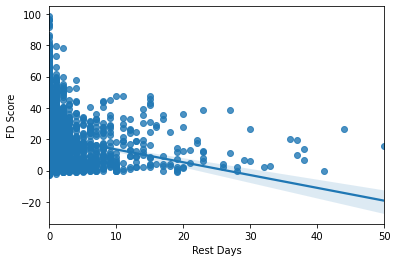

In [89]:
sns.regplot(x="Rest Days", y="FD Score", data=df_2018)

<AxesSubplot:xlabel='Personal Fouls', ylabel='FD Score'>

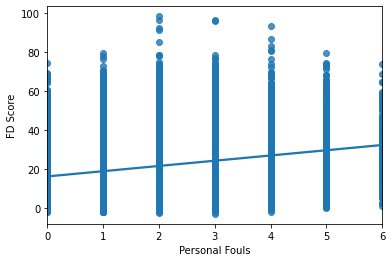

In [90]:
sns.regplot(x="Personal Fouls", y="FD Score", data=df_2018)

<AxesSubplot:xlabel='Team', ylabel='FD Score'>

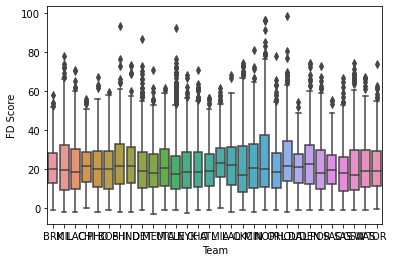

In [91]:
sns.boxplot(x="Team", y="FD Score", data=df_2018)

<AxesSubplot:xlabel='Position', ylabel='FD Score'>

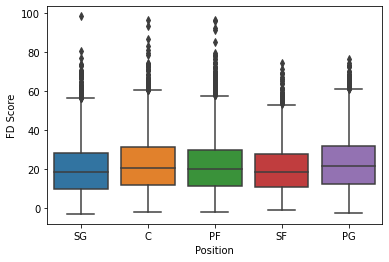

In [67]:
sns.boxplot(x="Position", y="FD Score", data=raw_df_2018)

<AxesSubplot:xlabel='Games Started', ylabel='FD Score'>

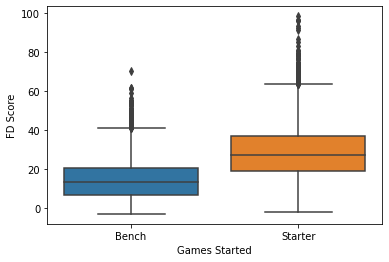

In [68]:
sns.boxplot(x="Games Started", y="FD Score", data=raw_df_2018)

In [69]:
df_2018['FD Score'].value_counts()

0.0     465
1.2     209
3.0     159
2.0     144
3.2     131
       ... 
83.0      1
63.4      1
81.0      1
29.6      1
39.6      1
Name: FD Score, Length: 854, dtype: int64

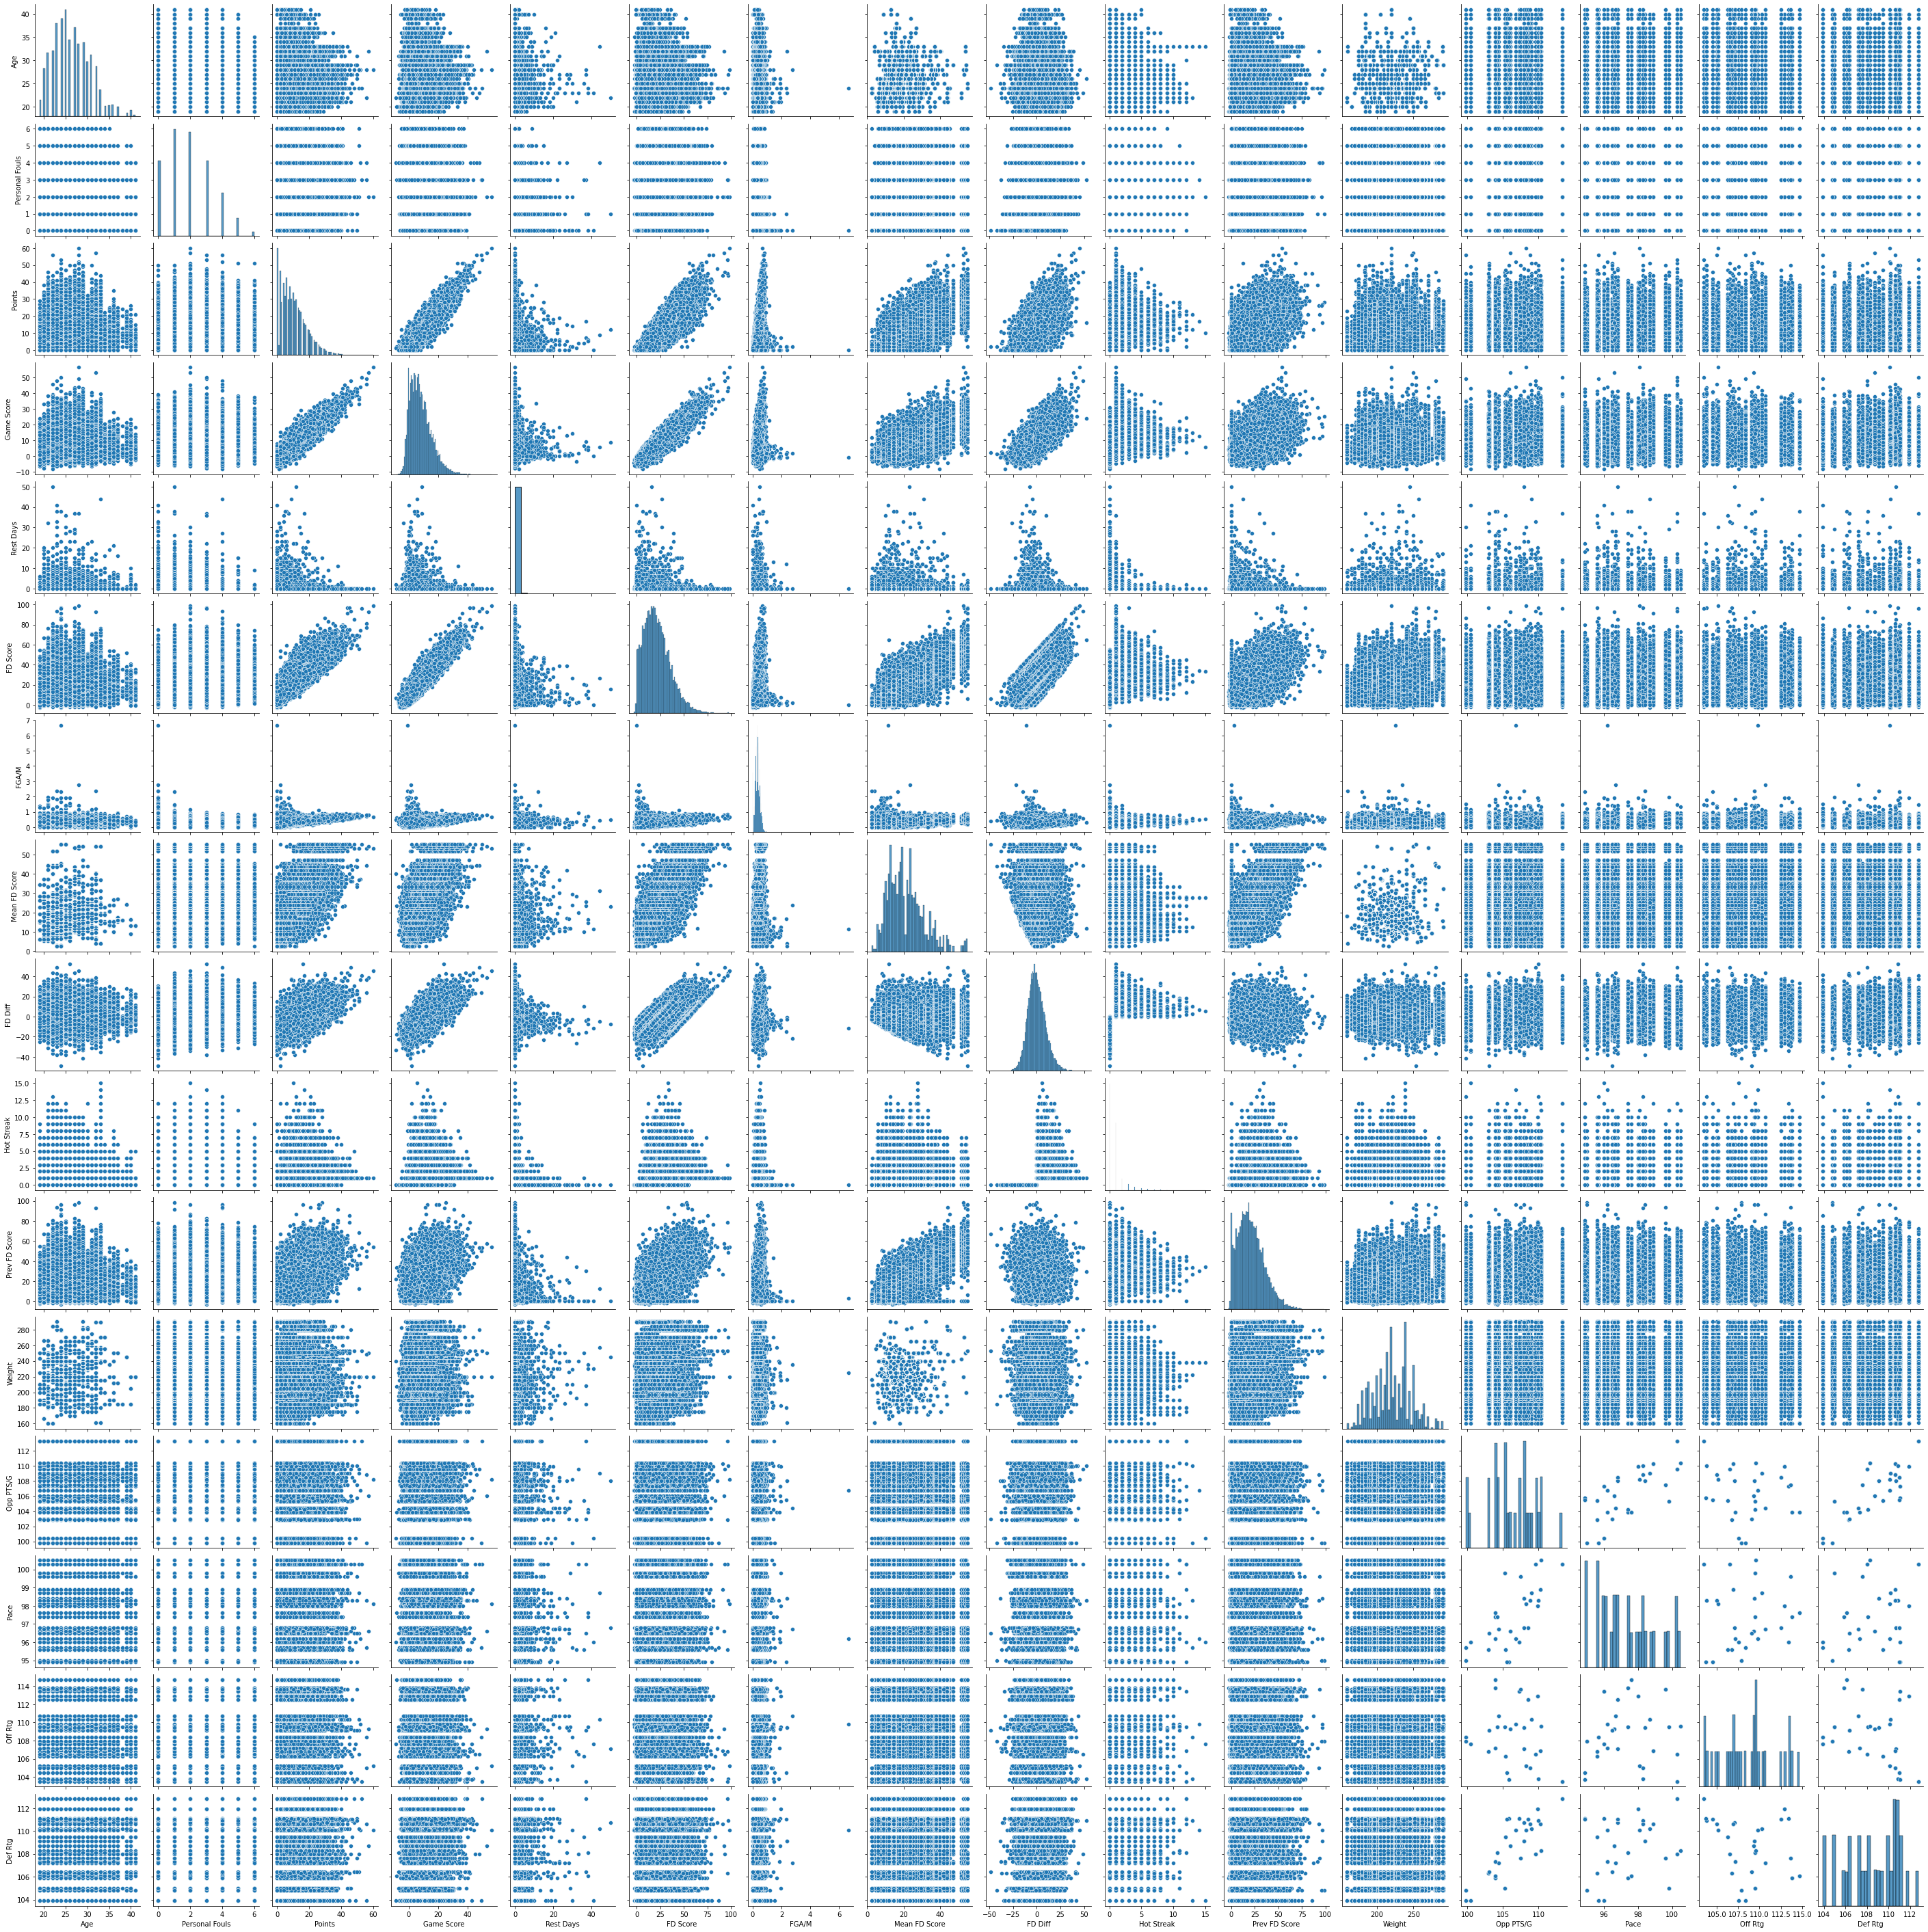

In [71]:
sns.pairplot(raw_df_2018)

In [92]:
lm = LinearRegression()

In [74]:
pf = PolynomialFeatures(degree=2)

In [105]:
X_train, X_test, y_train, y_test = train_test_split(df_2018_features, df_2018_target, test_size=0.3, random_state=42)

In [106]:
lm.fit(X_train,y_train)
y_pred = lm.predict(X_test)

In [111]:
lm.score(X_train, y_train)

0.6738094675440953

In [108]:
r2_score(y_pred, y_test)

0.5010609558840522